https://arxiv.org/abs/2103.05016.

# Hierarchical mergers of binary black holes
Goal of the project:

Understand the differences between hierarchical binary black hole mergers in nuclear star clusters, globular clusters and young star clusters, by looking at a set of simulated binary black holes

Tasks:

* Plot the main properties of hierarchical black holes in different star clusters. Compare nuclear star clusters, globular clusters and young star clusters

* Run some simple machine learning algorithm (e.g., a random forest) to figure out what features have the highest impact on the fate of a binary black hole in the three different kinds of star clusters.

### CONTENTS
1. Introduction 
2. Dataset organization 
3. Comparative plots of main properties
4. PCA analysis
5. Random Forest algorithm 
6. hyperparameters analysis
7. Conclusions


### INTRODUCTION 
A binary black hole can form via close encounters of black holes in a dense stellar environment, such as a nuclear star cluster, a globular cluster or a young star cluster. Nuclear star clusters are very massive (more o less 1e5 – 1e8 solar masses) star clusters lying at the center of some galaxies, including the Milky Way. Globular clusters are old (more or less 12 Gyr) massive (more or less 1e4 – 1e6) stellar clusters lying in the halo of almost every galaxy. Young star clusters are young (< 100 Myr) stellar clusters forming mostly in the disk of a galaxy.

#### What are generations?
Two black holes may be single objects at birth, and pair up dynamically at some point in their “life”. When two stellar-born black holes merge via gravitational wave emission, their merger remnant is called second-generation (2g) black hole. The 2g black hole is a single object at birth. However, if it is retained inside its host star cluster, it may pair up dynamically with another black hole. This gives birth to what we call a second-generation (2g) binary black hole, i.e. a binary black hole that hosts a 2g black hole . If a 2g binary black hole merges again, it gives birth to a third- generation (3g) black holes, and so on. In this way, repeated black hole mergers in star clusters can give birth to hierarchical chains of mergers, leading to the formation of more and more massive black holes.

### LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import linalg as la
from scipy.spatial import ConvexHull
import sklearn as skl
import sklearn.metrics as skm
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import StandardScaler#
import time

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


##OUR DATA

Our data was composed by three datasets, each containing informations on binary systems in different types of star clusters. In each dataset, the data was previously organized in columns for an easier analysis. For our study we used the following columns:




*   C0: Identifier of the binary.
*   C1: Mass of the primary black hole. 

*   C2: Mass of the secondary black hole.
*   C3: Dimensionless spin magnitude of the primary black hole.

*   C4: Dimensionless spin magnitude of the secondary black hole.
*   C9: Time requested for the dynamical pair up of the system.

*   C13: Time elapsed since the first-gen formation until the merger of the nth-gen sytem.
*   C15: Mass of the remnant.
*   C16: Dimensionless spin magnitude of the remnant black hole.
*   C17: Escape velocity from star cluster.

*   C25: Total mass of the stelar cluster.
*   C27: Number of generation of the system.

Additionally, for the machine learning study, the metallicity of the system was added as another column (C28).















##Getting the data

Since for each part of the project a different format of the data was more convenient, two similar but different codes were made to extract the data from the files and store it.


For the plotting part it was more useful to store the data on a dataframe. For this reason we read the files we were interested in and concatenate the data of each star cluster into different datasets.

In [2]:
folder = ['GC_chi01_output_noclusterevolv', 'NSC_chi01_output_noclusterevolv',
           'YSC_chi01_output_noclusterevolv']

name = 'nth_generation.txt'

metallicity = ['0.0002', '0.002', '0.02', '0.0004', '0.004', '0.006', '0.0008',
               '0.008', '0.0012', '0.012', '0.0016', '0.016']

def choose_set(c,m):
    #for this part is important to have the data stored on a folder called 'data' 
    file = pd.read_csv('data/' + folder[c] + '/Dyn/' + metallicity[m] + '/' + name, 
                   engine='python', sep = ' ')
    df_all = pd.DataFrame(file)
    df_all = df_all.drop(columns = [df_all.columns[28]] )
    
    '''
    There was an issue with the 13th column name, it has an space on it so pd.read_csv
    take that space also as a delimiter for another column. I solved it by deleting the 
    last column that was full of Nan (since it has nothing to read) and renaming the
    columns with 'col_name'
    '''
    col_name = ['c' + str(i) for i in range(28)]
    df_all.columns = col_name

    '''
    Here it was dropped the columns not bolded
    '''
    #here i remove the colums with 'ignore them' written on them
    df_all = df_all.drop(columns = ['c10', 'c11', 'c12', 'c18', 'c19', 'c20', 'c21',
                                'c22', 'c23', 'c24', 'c26'])
    #with this we just mantain the bolded ones.
    df_filtered = df_all.drop(columns = ['c5', 'c6', 'c7', 'c8', 'c14'])

    #As suggested in the methodology, ONLY for the purpose of visualization, we drop also columns 0, 9 and 13
    df_filt = df_filtered.drop(columns = ['c0', 'c9', 'c13']) 
    
    return df_filt

On the other hand, for the machine learning part, it was more convenient to store all the data together, since the porpuse of this part was to discern the star cluster each system belong to. This was done on a similar way as before, we first stored all the data into dataframes, concatenating them while reading each file. Once all the data was in a single dataframe, it was stored as a numpy array on a .npz file. This way we also avoid to read all the files each time we want to run the code. In addition, while reading the data of each star cluster, another array was made to assign a label to each system. This label array was also stored in the same .npz file.

In [ ]:
def get_data( nfiles):
    name = 'nth_generation.txt'
    
    folder = ['GC_chi01_output_noclusterevolv', 'NSC_chi01_output_noclusterevolv',
               'YSC_chi01_output_noclusterevolv']
    
    metallicity = ['0.0002', '0.002', '0.02', '0.0004', '0.004', '0.006', '0.0008',
                   '0.008', '0.0012', '0.012', '0.0016', '0.016']
                   
    col_name = ['c' + str(i) for i in range(28)]
    Y =[]
    t1 = time.time()
    for i in range(len(folder)):
        for j in range(nfiles):
            
            file = pd.read_csv('data/' + folder[i] + '/Dyn/' + metallicity[j] + '/' + name, 
                               engine='python', sep = ' ')
            
            df_all = pd.DataFrame(file)
            df_all = df_all.drop(columns = [df_all.columns[28]] )
            
            
            df_all.columns = col_name
    
            
            #here i remove the colums with 'ignore them' written on them
            df_all = df_all.drop(columns = ['c10', 'c11', 'c12', 'c18', 'c19', 'c20', 'c21',
                                            'c22', 'c23', 'c24', 'c26'])
                
            #with this we just mantain the bolded ones.
            df_filter = df_all.drop(columns = ['c5', 'c6', 'c7', 'c8', 'c14'])
            
            #here i define the metallicity
            met = pd.Series(np.array([float(metallicity[j]) for i in range(df_all.shape[0])]), name = 'c28')
            
            #here i add the metallicity as another column
            df_all = pd.concat([df_all, met],axis = 1)
            df_filter = pd.concat([df_filter, met],axis = 1)
            
            #convert df into arrays 
            
            
            df_filter = np.array(df_filter)        
            df_all = np.array(df_all)
            
            
            if i == 0 and j==0:
                X_all = df_all
                X_filter = df_filter
                
            else:
                
                X_all = np.concatenate((X_all, df_all))
                X_filter = np.concatenate((X_filter, df_filter))
                
        if i == 0: #label 0 for globular cluster
            Y= np.array([0 for k in range(X_filter.shape[0])])
        elif i == 1: #label 1 for nuclear star cluster
            y = np.array([1 for k in range(X_filter.shape[0]-len(Y))])
            Y = np.concatenate((Y, y))
        elif i == 2: #label 2 for young star cluster
            y = np.array([2 for k in range(X_filter.shape[0]-len(Y))])
            Y = np.concatenate((Y, y))
    t2 = time.time()
    print('time---- ', t2-t1)
    return X_all, X_filter, Y

In [ ]:
X_all, X_filter, Y = get_data( nfiles = 12)

np.savez('datasetBH', Xall=X_all, Xfilt=X_filter, Y=Y)


FileNotFoundError: ignored

The columns without 'ignore them' but not bolded were also stored but they did not shown better performance.

##Plotting

In order to visualize the main proprieties of the clusters and compare them, the dataframes is divided into some sub-dataframe collected into a dictionary. In this way it is possibile to recall a precise dataframe characterized by the cluster, metallicity and number of generation.

To simplify the visualization of some dependencies, sub-dataframes with a variance less than zero and with a number of counts lower than 10 were dropped. Furthermore, a filter has been performed on the spins, imposing that the spin magnitude of the black hole was at least 0.75.

In [ ]:
octopus=dict() #Dictionary used to collect all the dataframes divided by generation, cluster and metallicity.
#I choose dictionary and not an array because I don't know a priori the dimension
whale=np.zeros((3, 4)) #Array to collect the max generation of each dataframe divided by cluster and metallicity
moray=np.zeros((3, 4)) #Array that I will use to show the different max generations created by each cluster
meta={0:3,1:10,2:5,3:11} #I choose only 4 metallicities to make the visualization simpler
for c in range(0,3): #for every cluster: 0 is GC, 1 is NSC and 2 is YSC
    squid=dict() #Dictionary used to collect the dataframes divided by generation and metallicity
    for m in range(0,4):
        df_plot=choose_set(c,meta[m])
        #now I want to give columns a proper name:
        df_plot= df_plot.set_axis(["mass primary BH $(M_\u2609)$","mass secondary BH $(M_\u2609)$","spin magnitude primary BH","spin magnitude secondary BH","mass remnant BH $(M_\u2609)$","spin magnitude remnant BH","escape velocity from cluster $(km/s^{-1})$","total mass cluster $(M_\u2609)$","n of generation"], axis=1)
    
        #I divide the dataset by the number of generation

        max_gen=df_plot['n of generation'].max() #I suppose that every set could have a different max generation
        moray[c][m]=int(max_gen)
        jellyfish=dict() #Dictionary to collect the filtred dataframes divided by generation
        for i in range(2,max_gen+1):
            df_i=df_plot[(df_plot['n of generation'] == i)]
            #to visualize the main relations, a filter on the spins is made:
            df_i=df_i[(df_i["spin magnitude remnant BH"]>0.75)]
            if df_i["mass primary BH $(M_\u2609)$"].var()>0 and df_i["mass primary BH $(M_\u2609)$"].count()>10: #I impose this condition because I don't want empty plots
                jellyfish[i] = df_i 
        whale[c][m]=int(max(jellyfish.keys()))  #max of the filtred dictionaries for each metallicity
        squid[m]=jellyfish
    octopus[c]=squid

FileNotFoundError: ignored



> **HISTOGRAMS**




The sub-dataframes are used to compare the different main features (mass, spin and velocity) between the different clusters. An additional comparison is made between generations and metallicity.

**MASSES**

The first feature compared are the masses of the primary and secondary BH merged. This first analysis is made on basic values of metallicity (0,004) and for 2nd generation. The reason for this choice lies in the fact that we want to show only the general relations between the masses of the three clusters.

In [ ]:
starfish=whale.astype(int).T #I need to transpose the matrix because now the loops will be ordered differently
#each row is the max number of generation of the three different cluster with the same metallicity
colors=["skyblue","crimson","aquamarine","royalblue","salmon","springgreen","rebeccapurple","firebrick","yellow","hotpink","seagreen","orchid","gold","coral","forestgreen"] #15 
clusters=["GC","NSC","YSC"] #for cluster labels
metall=["0,004","0,0016","0,006","0,016"] #for metallicity labels
mean=np.zeros((3,4,5)) #to collect the medium values
var=np.zeros((3,4,5)) #to collect the variances

#I make a first plot to look at the general masses.  
#I fix the value of metallicity to 0.004 and I consider only the 2g for semplicity
fig,(axm1,axm2)= plt.subplots(nrows=2, ncols=1,figsize=(10,6),sharex=True,sharey=True)
fig.tight_layout()
for c in range(0,3):
    sns.kdeplot(octopus[c][0][2]["mass primary BH $(M_\u2609)$"], shade=True, ax=axm1,label="primary 2g BH for "+clusters[c],color=colors[c],alpha=0.5)
    sns.kdeplot(octopus[c][0][2]["mass secondary BH $(M_\u2609)$"], shade=True, ax=axm2,label="secondary 2g BH for "+clusters[c],color=colors[c],alpha=0.5)
    axm1.set_title('mass primary BH 2g for metallicity 0,004',fontsize = 15)
    axm1.set_ylabel('Density')
    axm1.legend(loc="best")
    axm2.set_title('mass secondary BH 2g for metallicity 0,004',fontsize = 15)
    axm2.set_xlabel('Masses ($M_\u2609$)')
    axm2.legend(loc="best")
    axm1.grid(visible=True, axis='both', alpha=0.2)
    axm2.grid(visible=True, axis='both', alpha=0.2)

The masses of the primary and secondary black holes presents different values depending on the cluster. Nuclear and Globular clusters' ones are slightly smaller than the holes in the Young Star Clusters, but the two partially overlap.

In [ ]:
for m in range(0,4):
    sns.set_palette(colors)
    fig1, ax1 = plt.subplots(figsize=(10,6))
    for g in range(2,max(starfish[m])+1):#in this way the number of relevant plot it's decided
        for c in range(0,3):
            if starfish[m][c]<g: #to avoid the jump of generation if a cluster doesn't have one
                break
            sns.kdeplot(octopus[c][m][g]["mass remnant BH $(M_\u2609)$"], shade=True, ax=ax1,label="BH "+str(g)+"g for "+clusters[c],alpha=0.5)
            ax1.set_title('Comparison of BH resultant masses for metallicity '+metall[m],fontsize = 15)
            ax1.set_xlabel('Masses ($M_\u2609$)')
            ax1.set_ylabel('Density')
            ax1.legend(loc="best")
            ax1.set_xticks(np.linspace(int(min(octopus[c][m][g]["mass remnant BH $(M_\u2609)$"]))-200,int(max(octopus[c][m][g]["mass remnant BH $(M_\u2609)$"]))+200,15))
            ax1.grid(visible=True, axis='both', alpha=0.2)

The previous plots show that the remnant masses after the merging of the primary and secondary holes are characterized by the cluster, the metallicity and the generation.
This last feature was quite obvious, however it can be seen how the resulting average mass increases generation by generation. With it, it increase also the variace, making the peaks more attenuated.
Another immediate result comes from the comparison between different clusters. Nuclear Star Clusters produce the smaller masses, but on the other hand they give rise to a higher number of generations. The YSC, on the other hand, give rise to larger masses but fewer generations.
A further comment can be done about metallicity: the mean values of the masses of all clusters divided by each generation decrease as the metallicity rise. This fact makes us think that the presence of elements other than hydrogen and helium in the clusters is relevant in the merging of binary black holes.

**SPINS**

Similarly to the previous section, in this first analysis we want to visualize only the generic differences between the spins of black holes in different clusters.

In [ ]:
figss,(axs1,axs2)= plt.subplots(nrows=2, ncols=1,figsize=(10,6),sharex=True,sharey=True)
figss.tight_layout()
for c in range(0,3):
    sns.kdeplot(octopus[c][0][2]["spin magnitude primary BH"], shade=True, ax=axs1,label="primary 2g BH for "+clusters[c],color=colors[c],alpha=0.5)
    sns.kdeplot(octopus[c][0][2]["spin magnitude secondary BH"], shade=True, ax=axs2,label="secondary 2g BH for "+clusters[c],color=colors[c],alpha=0.5)
    axs1.set_title('spin primary BH 2g for metallicity 0,004',fontsize = 15)
    axs1.set_ylabel('Density')
    axs1.legend(loc="best")
    axs2.set_title('spin secondary BH 2g for metallicity 0,004',fontsize = 15)
    axs2.set_xlabel('Spin magnitude')
    axs2.legend(loc="best")
    axs1.grid(visible=True, axis='both', alpha=0.2)
    axs2.grid(visible=True, axis='both', alpha=0.2)

It can be observed how, unlike the masses, in this case the spins of the first and second black holes are different from each other but similar for different clusters.

In [ ]:
for m in range(0,4):    
    fig2, ax2 = plt.subplots(figsize=(10,6))
    for g in range(2,max(starfish[m])+1):#in this way the number of relevant plot it's decided
        for c in range(0,3):
            if starfish[m][c]<g: #to avoid the jump of generation if a cluster doesn't have one
                break
            octopus[c][m][g]=octopus[c][m][g][(octopus[c][m][g]["spin magnitude remnant BH"]>0.75)]
            sns.kdeplot(octopus[c][m][g]["spin magnitude remnant BH"], shade=True, ax=ax2,label="BH "+str(g)+"g for "+clusters[c],alpha=0.5)
            #ax1.set_xticks(range(0,100))
            ax2.set_title('Comparison of BH resultant spins for metallicity '+metall[m],fontsize = 15)
            ax2.set_xlabel('Spin Magnitude')
            ax2.set_ylabel('Density')
            ax2.legend(loc="best")
            ax2.grid(visible=True, axis='both', alpha=0.2)  

In the previous plots we can see that initally, for 2g, the spins between the clusters are similar, similarly to the previous plot. When the number of generation increases, also the spin magnitude increases, even if it can be noted that the differences between 3 and 4 generations are small. In this case the metallicity acts slightly only in its higher values, reducing the spin, slowing down the BH.

**ESCAPE VELOCITIES**

As will be shown in the machine learing analysis, the most significant feature to distinguish the three clusters from each other is represented by the escape velocity. 

In [ ]:
fig444,axv1= plt.subplots(figsize=(10,6))
for c in range(0,3):
    sns.kdeplot(octopus[c][0][2]["escape velocity from cluster $(km/s^{-1})$"], shade=True, ax=axv1,label="escape velocity for "+clusters[c],color=colors[c],alpha=0.5)
    print("For "+clusters[c]+" the escape velocity is: ",octopus[c][0][2]["escape velocity from cluster $(km/s^{-1})$"].mean(),"+/-",octopus[c][0][2]["escape velocity from cluster $(km/s^{-1})$"].var(),"km/s^{-1}")
    axv1.set_title('Escape velocities for metallicity 0,004, 2g BH',fontsize = 15)
    axv1.set_ylabel('Density')
    axv1.legend(loc="best")
    axv1.grid(visible=True, axis='both', alpha=0.2)

From this plot it is already evident that the escape velocity is very different between the various clusters, moreover it is well defined for each of them (the variance is small) so it is reasonable to assume that this parameter can allow to uniquely distinguish the clusters between them.

In [ ]:
for m in range(0,4):
    sns.set_palette(colors)
    fig9, ax9 = plt.subplots(figsize=(10,6))
    for g in range(2,max(starfish[m])+1):#in this way the number of relevant plot it's decided
        for c in range(0,3):
            if starfish[m][c]<g: #to avoid the jump of generation if a cluster doesn't have one
                break
            sns.kdeplot(octopus[c][m][g]["escape velocity from cluster $(km/s^{-1})$"], shade=True, ax=ax9,label=str(g)+"g for "+clusters[c],alpha=0.5)
            ax9.set_title('Comparison of escape velocities for metallicity '+metall[m],fontsize = 15)
            ax9.set_xlabel('Velocity $(km/s^{-1})$')
            ax9.set_ylabel('Density')
            ax9.legend(loc="best")
            ax9.set_xticks(np.linspace(int(min(octopus[c][m][g]["escape velocity from cluster $(km/s^{-1})$"]))-10,int(max(octopus[c][m][g]["escape velocity from cluster $(km/s^{-1})$"]))+10,5))
            ax9.grid(visible=True, axis='both', alpha=0.2)

The very first observation that can be made is relative to the generations: once again the increase in generation corresponds to a higher value of the feature. 
Furthermore, again as proof of the fact that the escape velocities characterize the clusters well, it is observed that despite the advancement of the generations they do not get confused with those of the other clusters. Finally, it is noted that metallicity does not significantly affect this parameter.

**NUMBER OF GENERATIONS**

In the previous plots it has been observed that the number of generations produced is not the same for each cluster. This aspect is quantified in the following representation.

In [ ]:
#In this last histogram I want to show the differences between clusters 
fig3, ax3 = plt.subplots(figsize=(10,6))
for i in range(0,3):
    #print(moray[i])
    sns.kdeplot(moray[i], shade=True, ax=ax3,alpha=0.5,label=clusters[i])
    ax3.set_title('Max generation for each cluster',fontsize = 15)
    ax3.set_xlabel('Generation')
    ax3.set_ylabel('Density')
    ax3.legend(loc="best")
    ax3.grid(visible=True, axis='both', alpha=0.2) 

In this plot it can be visualized the different max number of generations that each cluster can produce. As previously mentioned, nuclear clusters produce an higher number of generations, even if they produce smaller masses.

**CLUSTER MASSES**

Before moving on to the scatter plots, one last significant feature is presented. 

In [ ]:
fig44,ax8= plt.subplots(figsize=(10,6))
for c in range(0,3):
    sns.kdeplot(octopus[c][0][2]["total mass cluster $(M_\u2609)$"], shade=True, ax=ax8,label="total mass cluster for "+clusters[c],color=colors[c],alpha=0.5)
    print("For "+clusters[c]+" the total mass is: ",octopus[c][0][2]["total mass cluster $(M_\u2609)$"].mean(),"+/-",octopus[c][0][2]["total mass cluster $(M_\u2609)$"].var(),"M_\u2609")
    ax8.set_title('Total masses for metallicity 0,004, 2g BH',fontsize = 15)
    ax8.set_ylabel('Density')
    ax8.set_xticks(np.linspace(-1000000,7000000,10))
    ax8.legend(loc="best")
    ax8.set_xlim(left=-1000000,right=7000000)
    ax8.grid(visible=True, axis='both', alpha=0.2)
    

Therefore the total mass cluster is a good indicator to distinguish young star clusters from the others two, but it does not clearly distinguish nuclear and globular from each other, since part of their masses are overlapping.



> **SCATTER PLOTS**



In the following plots some dependences between the features are shown. In order to do it, a single dataframe with all the meaningful data is created.

In [ ]:
dolphin=[0,0,0] #This time I use list and not dictionary to collect the dataframes outside the loops, because I want to concatenate all the dataframes
for c in range(0,3): 
    seahorse=[] #list to collect all the dataframes except clusters and then concatenate them
    for g in range(2,max(starfish[m])+1):
        for m in range(0,4):    
            if starfish[m][c]<g: #to avoid problems
                break
            octopus[c][m][g]["metallicity"]=metall[m] #I add the column of the metallicity
            seahorse.append(octopus[c][m][g]) #appending dataframes, so I can concatenate them
    dolphin[c]=pd.concat(seahorse,ignore_index=True)
    dolphin[c]=dolphin[c][(dolphin[c]["spin magnitude primary BH"]>0.5)]
    dolphin[c]=dolphin[c][(dolphin[c]["spin magnitude secondary BH"]>0.5)]
    dolphin[c]=dolphin[c][(dolphin[c]["n of generation"]<5)] #to have a better visualization of meaningful parameters
    dolphin[c]["cluster"]=clusters[c] #I add the column of the cluster
df=pd.concat(dolphin,ignore_index=True)
     

**MASSES**

In [ ]:
sns.set_theme()

sns.relplot(x="mass primary BH $(M_\u2609)$", y="mass remnant BH $(M_\u2609)$",  hue="cluster",style="n of generation",col="metallicity", data=df,alpha=0.3);
sns.relplot(x="mass secondary BH $(M_\u2609)$", y="mass remnant BH $(M_\u2609)$",  hue="cluster",style="n of generation",col="metallicity", data=df,alpha=0.3);
 

By looking at these first set of plots it can be observed that there's a dipendence between the mass of the primary/secondary BH and the merged BH, but it becomes less accurate increasing the total mass. Anyway that's not surpirsing because it depends also on the mass of the secondary/primary BH. Young Star Clusters, which are lighter, are predictably concentrated near the origin. It can also be seen a confirmation that the overall masses decrease as the metallicity increases.


**SPINS**

In [ ]:
sns.relplot(x="spin magnitude primary BH", y="spin magnitude remnant BH",  hue="cluster",style="n of generation",col="metallicity", data=df,alpha=0.3);
sns.relplot(x="spin magnitude secondary BH", y="spin magnitude remnant BH", hue="cluster",style="n of generation",col="metallicity", data=df,alpha=0.3);

The comparison of primary/secondary spin magitudes with the merged BH spin magnitude suggest that there may be a correlation between the two features, even if it is more defined for higher and lower spin magnitudes. Metallicity 0,016 suggests that for higher metallicity values the correlation could be more evident, but data are but the data are too few to be able to state it with certainty. Young star clusters have a smaller spin range, instead nuclear clsuters's range is wider.


In [ ]:
sns.relplot(y="escape velocity from cluster $(km/s^{-1})$", x="total mass cluster $(M_\u2609)$", hue="cluster",style="n of generation",col="metallicity", data=df,alpha=0.3);


It can be seen that the escape velocity has a logarithmic dependence on mass cluter. In addition, we can observe that a higher metallicity slightly decreases the escape velocities of the clusters. The Nuclear Cluters' velocities are considerably higher compared to the other two. In order to better visualize their characteristics, the following plot is restricted to globular and young clusters only.


In [ ]:
df=df[(df["cluster"]!="NSC")]
sns.relplot(y="escape velocity from cluster $(km/s^{-1})$", x="total mass cluster $(M_\u2609)$", hue="cluster",style="n of generation",col="metallicity", data=df,alpha=0.3);
 

With this last plot we can confirm the logarithmic relationship between the escape velocity and the masses of the clusters, as well as observe that the globular clusters escape faster than the young ones.
 

In conclusion, some significant differences between the three clusters can be observed from the plots. First of all, the values ​​of the masses of black holes are lower for the Nuclear Star Clusters and higher for the Youngs. These values are also affected by metallicity and, of course, generation. The escape velocities, on the other hand, are very high for the nuclear ones and low for the young ones, a parameter that will be seen to be decisive for the differentiation between the clusters. A similar dependency can be found by looking at the number of generations produced by each cluster. 
Also the range of the magnitude of spins can be useful to characterize the cluster: in fact it is shown that nuclear cluster's one are larger compared to the other two, instead the young's one is significantly smaller.

##PCA

##PCA comparison between different clusters

Principal component analysis (PCA) is a technique that allows to reduce the dimensionality of a dataset. In particular, data described by multiple features, can be represented by a fewer number of dymensions, corresponding to the so called 'principal components', all orthogonal with each other. Each principal component catches a certain amount of variability in the dataset. For this reason, before the analysis, it is possible to fix a reasonable threshold of variance we want to be represented and see how many principal components are needed to represent the data in the most complete way.

Below, after normalizig the data in order to reduce computation times, we used PCA on three datasets for a fixed metallicity and for each stellar cluster, with the only purpose of visualizing the data and seeing with a naked eye whether it is possible to distinguish three different clusters of points in the plots, corresponding to each stellar cluster. In order to do this, we chose the highest possible numbers of principal components that could be visualized (3 - 4). Furthermore, in order to have a quantitative estimation of how much the chosen numbers of principal components are representative of the original data, we also calculated the percentage of total represented variance.

In [3]:
#Fixing a metallicity
met = 0

#Data (features)
X_GC = choose_set(0, met) #Globular cluster data
X_NSC = choose_set(1, met) #Nuclear star cluster data
X_YSC = choose_set(2, met) #Young star cluster data

#Display dataframes
#display(X_GC)
#display(X_NSC)
#display(X_YSC)

#Data normalization to decrease computation time
X_GC = (X_GC - np.mean(X_GC, axis=0))/np.std(X_GC, axis=0)
X_NSC = (X_NSC - np.mean(X_NSC, axis=0))/np.std(X_NSC, axis=0)
X_YSC = (X_YSC - np.mean(X_YSC, axis=0))/np.std(X_YSC, axis=0)

#Display normalized dataframes
#display(X_GC)
#display(X_NSC)
#display(X_YSC)

#Check if mean is 0 and variance is 1
#print(np.mean(X_GC, axis=0), np.std(X_GC, axis=0))
#print(np.mean(X_NSC, axis=0), np.std(X_NSC, axis=0))
#print(np.mean(X_YSC, axis=0), np.std(X_YSC, axis=0))

PCA using 3 principal components, applied to each cluster separately and resume main features

In [4]:
pca = PCA(n_components=3)
principalComponents_GC = pca.fit_transform(X_GC)
principalDf_GC = pd.DataFrame(data = principalComponents_GC, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
print("Globular cluster:")
print('Fraction of variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Using 3 principal components we are able to represent the ', np.sum(pca.explained_variance_ratio_) * 100, '% of the variance of the data\n')

pca = PCA(n_components=3)
principalComponents_NSC = pca.fit_transform(X_NSC)
principalDf_NSC = pd.DataFrame(data = principalComponents_NSC, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
print("Nuclear star cluster:")
print('Fraction of variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Using 3 principal components we are able to represent the ', np.sum(pca.explained_variance_ratio_) * 100, '% of the variance of the data\n')

pca = PCA(n_components=3)
principalComponents_YSC = pca.fit_transform(X_YSC)
principalDf_YSC = pd.DataFrame(data = principalComponents_YSC, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
print("Young star cluster:")
print('Fraction of variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Using 3 principal components we are able to represent the ', np.sum(pca.explained_variance_ratio_) * 100, '% of the variance of the data\n')

Globular cluster:
Fraction of variation per principal component: [0.41153169 0.20889371 0.14218986]
Using 3 principal components we are able to represent the  76.26152541057586 % of the variance of the data

Nuclear star cluster:
Fraction of variation per principal component: [0.46146395 0.19442283 0.12673615]
Using 3 principal components we are able to represent the  78.26229320587292 % of the variance of the data

Young star cluster:
Fraction of variation per principal component: [0.40236267 0.1909579  0.15313336]
Using 3 principal components we are able to represent the  74.64539246269482 % of the variance of the data



Visualization of PCA using 3 principal components

<IPython.core.display.Javascript object>


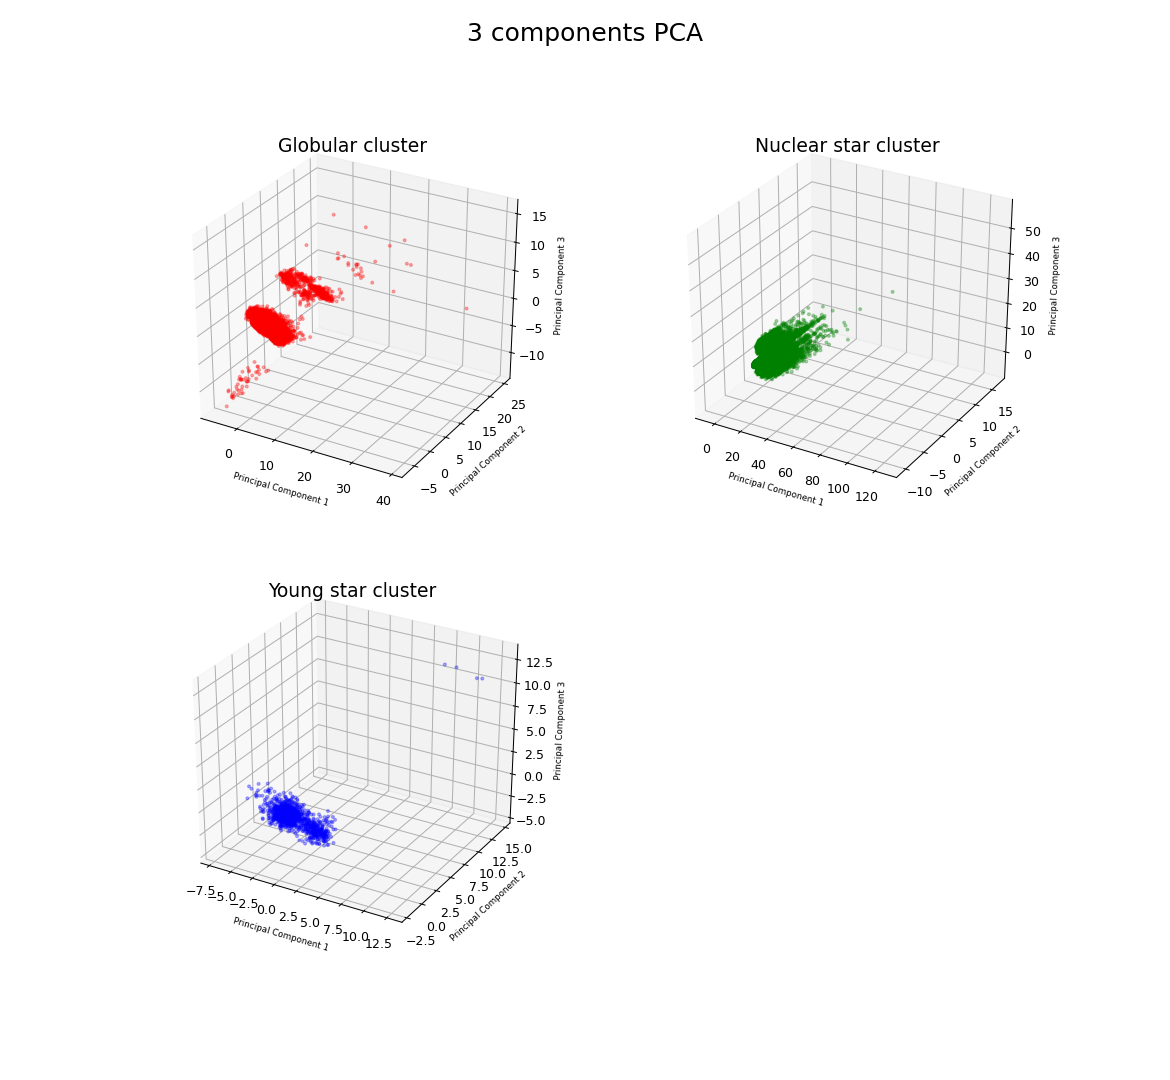

In [5]:
x_GC = np.array(principalDf_GC['principal component 1'])
y_GC = np.array(principalDf_GC['principal component 2'])
z_GC = np.array(principalDf_GC['principal component 3'])

x_NSC = np.array(principalDf_NSC['principal component 1'])
y_NSC = np.array(principalDf_NSC['principal component 2'])
z_NSC = np.array(principalDf_NSC['principal component 3'])

x_YSC = np.array(principalDf_YSC['principal component 1'])
y_YSC = np.array(principalDf_YSC['principal component 2'])
z_YSC = np.array(principalDf_YSC['principal component 3'])

fig = plt.figure(figsize=(13, 12))
fig.suptitle('3 components PCA', fontsize = 20)
ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(x_GC, y_GC, z_GC, c='r', s = 5, alpha=0.3)
ax1.set_xlabel('Principal Component 1', fontsize = 7)
ax1.set_ylabel('Principal Component 2', fontsize = 7)
ax1.set_zlabel('Principal Component 3', fontsize = 7)
ax1.set_title('Globular cluster', fontsize = 15)

ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(x_NSC, y_NSC, z_NSC, c='g', s = 5, alpha=0.3)
ax2.set_xlabel('Principal Component 1', fontsize = 7)
ax2.set_ylabel('Principal Component 2', fontsize = 7)
ax2.set_zlabel('Principal Component 3', fontsize = 7)
ax2.set_title('Nuclear star cluster', fontsize = 15)

ax3 = fig.add_subplot(223, projection='3d')
ax3.scatter(x_YSC, y_YSC, z_YSC, c='b', s = 5, alpha=0.3)
ax3.set_xlabel('Principal Component 1', fontsize = 7)
ax3.set_ylabel('Principal Component 2', fontsize = 7)
ax3.set_zlabel('Principal Component 3', fontsize = 7)
ax3.set_title('Young star cluster', fontsize = 15)

plt.show()

PCA using 4 principal components, applied to each cluster separately and resume main features

In [6]:
pca = PCA(n_components=4)
principalComponents_GC = pca.fit_transform(X_GC)
principalDf_GC = pd.DataFrame(data = principalComponents_GC, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4'])
print("Globular cluster:")
print('Fraction of variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Using 4 principal components we are able to represent the ', np.sum(pca.explained_variance_ratio_) * 100, '% of the variance of the data\n')

pca = PCA(n_components=4)
principalComponents_NSC = pca.fit_transform(X_NSC)
principalDf_NSC = pd.DataFrame(data = principalComponents_NSC, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4'])
print("Nuclear star cluster:")
print('Fraction of variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Using 4 principal components we are able to represent the ', np.sum(pca.explained_variance_ratio_) * 100, '% of the variance of the data\n')

pca = PCA(n_components=4)
principalComponents_YSC = pca.fit_transform(X_YSC)
principalDf_YSC = pd.DataFrame(data = principalComponents_YSC, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4'])
print("Young star cluster:")
print('Fraction of variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Using 4 principal components we are able to represent the ', np.sum(pca.explained_variance_ratio_) * 100, '% of the variance of the data\n')

Globular cluster:
Fraction of variation per principal component: [0.41153169 0.20889371 0.14218986 0.10181204]
Using 4 principal components we are able to represent the  86.44272950802694 % of the variance of the data

Nuclear star cluster:
Fraction of variation per principal component: [0.46146395 0.19442283 0.12673615 0.09340137]
Using 4 principal components we are able to represent the  87.60242971721178 % of the variance of the data

Young star cluster:
Fraction of variation per principal component: [0.40236267 0.1909579  0.15313336 0.1107241 ]
Using 4 principal components we are able to represent the  85.7178029231391 % of the variance of the data



Visualization of PCA using 4 principal components

<IPython.core.display.Javascript object>


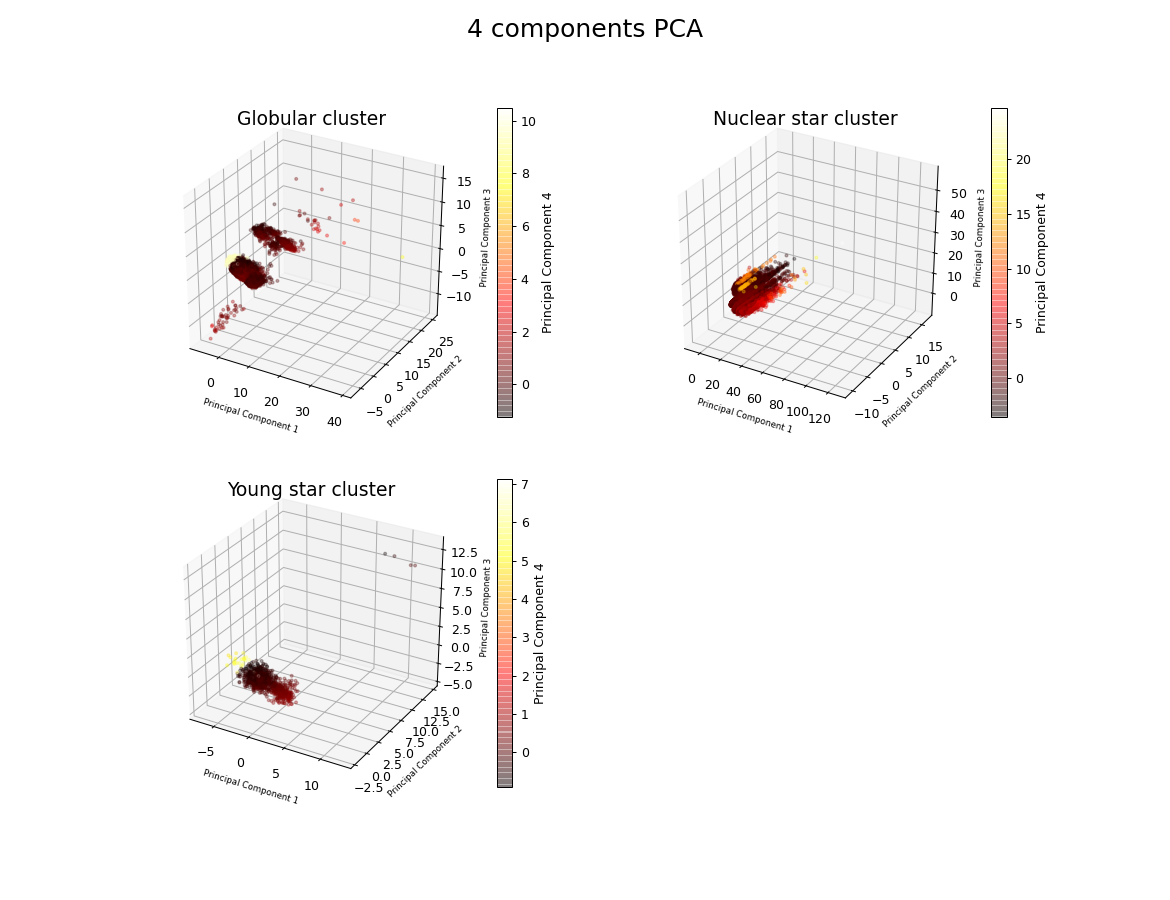

In [7]:
x_GC = np.array(principalDf_GC['principal component 1'])
y_GC = np.array(principalDf_GC['principal component 2'])
z_GC = np.array(principalDf_GC['principal component 3'])
c_GC = np.array(principalDf_GC['principal component 4'])

x_NSC = np.array(principalDf_NSC['principal component 1'])
y_NSC = np.array(principalDf_NSC['principal component 2'])
z_NSC = np.array(principalDf_NSC['principal component 3'])
c_NSC = np.array(principalDf_NSC['principal component 4'])

x_YSC = np.array(principalDf_YSC['principal component 1'])
y_YSC = np.array(principalDf_YSC['principal component 2'])
z_YSC = np.array(principalDf_YSC['principal component 3'])
c_YSC = np.array(principalDf_YSC['principal component 4'])

fig = plt.figure(figsize=(13, 10))
fig.suptitle('4 components PCA', fontsize = 20)
ax1 = fig.add_subplot(221, projection='3d')
img1 = ax1.scatter(x_GC, y_GC, z_GC, c=c_GC, cmap=plt.hot(), s = 5, alpha=0.3)
fig.colorbar(img1, label='Principal Component 4')
ax1.set_xlabel('Principal Component 1', fontsize = 7)
ax1.set_ylabel('Principal Component 2', fontsize = 7)
ax1.set_zlabel('Principal Component 3', fontsize = 7)
ax1.set_title('Globular cluster', fontsize = 15)

ax2 = fig.add_subplot(222, projection='3d')
img2 = ax2.scatter(x_NSC, y_NSC, z_NSC, c=c_NSC, cmap=plt.hot(), s = 5, alpha=0.3)
fig.colorbar(img2, label='Principal Component 4')
ax2.set_xlabel('Principal Component 1', fontsize = 7)
ax2.set_ylabel('Principal Component 2', fontsize = 7)
ax2.set_zlabel('Principal Component 3', fontsize = 7)
ax2.set_title('Nuclear star cluster', fontsize = 15)

ax3 = fig.add_subplot(223, projection='3d')
img3 = ax3.scatter(x_YSC, y_YSC, z_YSC, c=c_YSC, cmap=plt.hot(), s = 5, alpha=0.3)
fig.colorbar(img3, label='Principal Component 4')
ax3.set_xlabel('Principal Component 1', fontsize = 7)
ax3.set_ylabel('Principal Component 2', fontsize = 7)
ax3.set_zlabel('Principal Component 3', fontsize = 7)
ax3.set_title('Young star cluster', fontsize = 15)

plt.show()

Using 3 and 4 principal components we can see that the accuracy is not very high, in fact the total represented variance is around 76% for 3 principal components description and around 86% for 4. However, this analysis was only meant for visualization purposes.

PCA using 6 principal components, applied to each cluster separately and resume main features

In [8]:
pca = PCA(n_components=6)
principalComponents_GC = pca.fit_transform(X_GC)
principalDf_GC = pd.DataFrame(data = principalComponents_GC, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'principal component 6'])
print("Globular cluster:")
print('Fraction of variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Using 6 principal components we are able to represent the ', np.sum(pca.explained_variance_ratio_) * 100, '% of the variance of the data\n')

pca = PCA(n_components=6)
principalComponents_NSC = pca.fit_transform(X_NSC)
principalDf_NSC = pd.DataFrame(data = principalComponents_NSC, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'principal component 6'])
print("Nuclear star cluster:")
print('Fraction of variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Using 6 principal components we are able to represent the ', np.sum(pca.explained_variance_ratio_) * 100, '% of the variance of the data\n')

pca = PCA(n_components=6)
principalComponents_YSC = pca.fit_transform(X_YSC)
principalDf_YSC = pd.DataFrame(data = principalComponents_YSC, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'principal component 6'])
print("Young star cluster:")
print('Fraction of variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Using 6 principal components we are able to represent the ', np.sum(pca.explained_variance_ratio_) * 100, '% of the variance of the data\n')

Globular cluster:
Fraction of variation per principal component: [0.41153169 0.20889371 0.14218986 0.10181204 0.06201803 0.0376177 ]
Using 6 principal components we are able to represent the  96.40630310942227 % of the variance of the data

Nuclear star cluster:
Fraction of variation per principal component: [0.46146395 0.19442283 0.12673615 0.09340137 0.05725127 0.03343259]
Using 6 principal components we are able to represent the  96.67081565193942 % of the variance of the data

Young star cluster:
Fraction of variation per principal component: [0.40236267 0.1909579  0.15313336 0.1107241  0.05195747 0.043159  ]
Using 6 principal components we are able to represent the  95.22944916417123 % of the variance of the data



Using 6 principal components, instead, we are able to represent about 96% of the total variability, which is a reasonably accurate result, however, difficult to visualize.

In principle, we could now train a clustering algorithm in order to assign every collection of features, described by the principal components, to the right stellar cluster. However, this would not give any information on which are the original features that influences the most on the fate of a binary black hole in the three different kinds of star clusters. In fact it is not possible to directly link the information contained in the principal components, back to the original features in the dataset.

##PCA used to "clusterize" BH mergers generations inside a choosen stellar cluster

Below we used again the PCA, but in a different way. Here we visualized the data for a fixed star cluster and metallicity, and then 'clusterized' the numbers of generations of the mergers. The purpose consists in investigating wether it is possible to discriminate between different generations for a same cluster and metallicity. As was told us from prof. Mapelli, we should expect to be barely able to distinguish the second generation from the others.

In [9]:
#Fixing a metallicity and a stellar cluster
met = 0
clus = 0

#Data
df_filt=choose_set(clus, met)

X = np.array(df_filt.drop(columns = ['c27']) ) #Features
X = (X - np.mean(X, axis=0))/np.std(X, axis=0) #Features normalization in order to decrease computation time
#X = StandardScaler().fit_transform(X) #Alternative way of normalizing data
Y = np.array( df_filt['c27'] ) #Labels (merger BH generation)

#Check if mean is 0 and variance is 1
#print(np.mean(X, axis=0))
#print(np.std(X, axis=0))

PCA using 3 principal components, applied to the features of a single cluster and resume main properties

In [10]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
print('Fraction of variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Using 3 principal components we are able to represent the ', np.sum(pca.explained_variance_ratio_) * 100, '% of the variance of the data')

Fraction of variation per principal component: [0.44174553 0.21934681 0.11707139]
Using 3 principal components we are able to represent the  77.81637391202906 % of the variance of the data


Visualization of PCA using 3 principal components

<IPython.core.display.Javascript object>


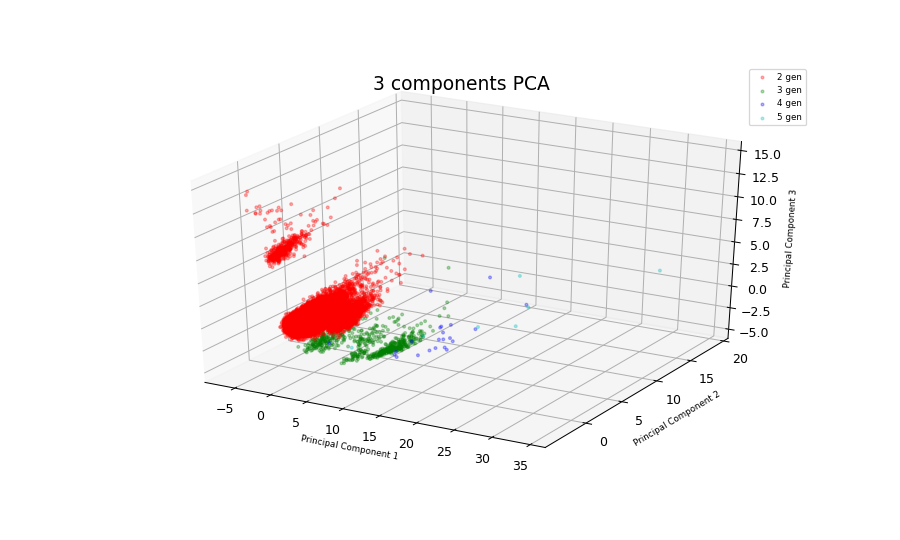

In [11]:
x = np.array(principalDf['principal component 1'])
y = np.array(principalDf['principal component 2'])
z = np.array(principalDf['principal component 3'])

classes = np.unique(Y)
colors = np.array(['r', 'g', 'b', 'c', 'm', 'y', 'orange', 'gray', 'pink', 'brown', 'salmon', 'chocolate', 'lawngreen', 'lightgreen', 'darkcyan', 'steelblue', 'magenta'])
leg = np.array([])
for val in classes: leg = np.append(leg, str(val) + ' gen') 

fig = plt.figure(figsize(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 7)
ax.set_ylabel('Principal Component 2', fontsize = 7)
ax.set_zlabel('Principal Component 3', fontsize = 7)
ax.set_title('3 components PCA', fontsize = 15)

for classes, colors in zip(classes, colors[0:len(classes)]):
    indicesToKeep = Y == classes
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1'], principalDf.loc[indicesToKeep, 'principal component 2'], principalDf.loc[indicesToKeep, 'principal component 3'], c=colors, s = 5, alpha=0.3)

plt.legend(leg ,prop={'size': 7}, loc='best')
plt.show()

PCA using 4 principal components, applied to the features of a single cluster and resume main properties

In [12]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4'])
print('Fraction of variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Using 4 principal components we are able to represent the ', np.sum(pca.explained_variance_ratio_) * 100, '% of the variance of the data')

Fraction of variation per principal component: [0.44174553 0.21934681 0.11707139 0.11145858]
Using 4 principal components we are able to represent the  88.96223172605917 % of the variance of the data


Visualization of PCA using 4 principal components

<IPython.core.display.Javascript object>


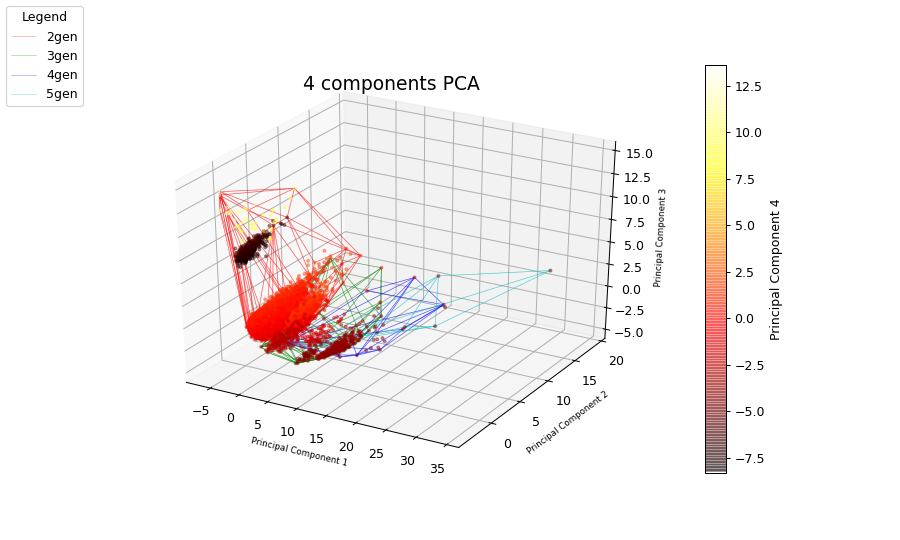

In [13]:
x = np.array(principalDf['principal component 1'])
y = np.array(principalDf['principal component 2'])
z = np.array(principalDf['principal component 3'])
c = np.array(principalDf['principal component 4'])

classes = np.unique(Y)
colors = np.array(['r', 'g', 'b', 'c', 'm', 'y', 'orange', 'gray', 'pink', 'brown', 'salmon', 'chocolate', 'lawngreen', 'lightgreen', 'darkcyan', 'steelblue', 'magenta'])
leg = np.array([])
for val in classes: leg = np.append(leg, str(val) + ' gen') 
h = np.array([])
l = np.array([])

fig = plt.figure(figsize(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 7)
ax.set_ylabel('Principal Component 2', fontsize = 7)
ax.set_zlabel('Principal Component 3', fontsize = 7)
ax.set_title('4 components PCA', fontsize = 15)
img = ax.scatter(x, y, z, c=c, cmap=plt.hot(), alpha=0.4, s=5) # Plot data points
fig.colorbar(img, label='Principal Component 4')

for classes, colors in zip(classes, colors[0:len(classes)]):
    cnt = 0
    indicesToKeep = Y == classes
    points = np.array((principalDf.drop(columns = 'principal component 4')).loc[indicesToKeep])
    if len(points) > 3:
        hull = ConvexHull(points) # Get convex hull
        for s in hull.simplices:
            s = np.append(s, s[0]) # Repeat last point to close the polygon
            ax.plot(points[s, 0], points[s, 1], points[s, 2], '-', c=colors, linewidth=0.5, alpha=0.4, label=(str(classes)+'gen')) # Plot 'cluster' lines
        h = np.append(h, np.array(ax.get_legend_handles_labels())[:, -1][0])
        l = np.append(l, np.array(ax.get_legend_handles_labels())[:, -1][1])
    else:
        ax.plot(points[:, 0], points[:, 1], points[:, 2], '-', c=colors, linewidth=0.5, alpha=0.4, label=(str(classes)+'gen')) # Plot 'cluster' lines
        h = np.append(h, np.array(ax.get_legend_handles_labels())[:, -1][0])
        l = np.append(l, np.array(ax.get_legend_handles_labels())[:, -1][1])
    cnt += 1 

fig.legend(h, l, loc='upper left', title='Legend')
plt.show()

Choosing clus=0 and met=0, we see that second generation mergers are well distinguishable from the others. On the contrary, choosing for exaple clus=1 and met=5, clustering for second generation mergers become difficult if not imposible to appreciate.

In conclusion, we can observe that PCA was certainly useful to have an intuition of how data are distributed in function of a fixed number of principal components. However, the difficulty of linking the visualized results to the original features, suggests the use of a more suitable machine learning algorithm, in order to understand which are the features of the data that impact the most on the fate of a binary black hole on the three stellar clusters.


##RANDOM FOREST

What are random Forests?

Random forest is a Supervised Machine Learning Algorithm that is used widely in Classification problems. It builds decision trees on different samples and takes their majority vote for classification. Each Decision Tree is a set of internal nodes and leaves. In the internal node, the selected feature is used to make decision how to divide the data set into two separate sets with similars responses within. The features for internal nodes are selected with some criterion, which for classification tasks can be gini impurity or infomation gain. Since decisions trees are very sensitive to the data they are trained on (small changes to the training set can result in significantly different tree structures), random forest allow each individual tree to randomly sample from the dataset with replacement, resulting in different trees. This process is known as bagging. Furthermore: each tree in a random forest can pick only from a random subset of features. This forces even more variation amongst the trees in the model and ultimately results in lower correlation across trees and more diversification.


First we upload out data, normalize it and split it into train and test set

In [ ]:
xns = np.load('datasetBH.npz') 
X = xns['Xfilt']
Y = xns['Y']

Once our data is uploaded, it is important to normalize it. The normalization of the data has a huge impact on the performance of machine learning algorithms. Non normalizing it could make the algorithm to not converge while fitting the data or even not beeing able to fit it.

In [ ]:
ID=4607431
np.random.seed(ID) #we define a seed to permute out data

def split_norm( X, Y):
    #split the data into train and test set (70%-30%)
    m = X.shape[0]
    m_train = int(0.7*m)
    m_test = m - m_train
    #split and permute the data (train-test)
    permutation = np.random.permutation(m) # random permutation
    X = X[permutation,:]
    Y = Y[permutation]
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = m_test )
    #normalizing the data 
    scaler = preprocessing.StandardScaler().fit(X_train) 
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test) # use the same transformation on test data
    
    print(X_train[:10]) #we print 10 samples of to have a look on the dataset.
    return X_train,X_test ,Y_train ,Y_test

X_train, X_test, Y_train, Y_test = split_norm(X, Y)


labels, freqs = np.unique(Y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

It is important to have a look on the frequencies of our labels, as we can see they are not homogeneous which can lead the model to be biased by the predominant label while giving a high score over the test set. This way we can now take that into account while creating our model.

From the whole dataset we can take a small dataset to look for the best hyperparameters that later will conform our model. 




In [ ]:
m_training = 10000
permutation = np.random.permutation(m_training)
X_train = X_train[permutation,:]
Y_train = Y_train[permutation]
X_train = X_train[:m_training]
Y_train = Y_train[:m_training]
labels, freqs = np.unique(Y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

Let's try first to see the performance of a very simple forest and the most important features that it predicts.
Now we are using a random forest characterized by 10 decision trees (n_estimators) and balanced class_weight is a parameter that takes in account the strong asymmetry between number of samples in each cluster. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=10, class_weight = 'balanced')
forest.fit(X_train, Y_train)
preds = forest.predict(X_test)
col_names = ['c0','c1', 'c2','c3', 'c4','c9','c13','c15','c16', 'c17', 'c25','c27', 'c28' ]

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

plt.bar(col_names,forest.feature_importances_, yerr=std) #the importance of every feature
plt.title("Random Forest Feature Importance using MDI",fontsize=20 )
plt.ylabel("Mean decrease in impurity", fontsize=15)
#plt.tight_layout()



We can organize this preliminary results on a more visual way

In [ ]:
#to have a better vision of feature importance
sorted_idx = forest.feature_importances_.argsort()
#print(sorted_idx)
col_names=np.array(col_names)
std = np.array(std)
plt.bar(col_names[sorted_idx], forest.feature_importances_[sorted_idx], yerr=std[sorted_idx])
plt.title("Random Forest Feature Importance using MDI",fontsize=20 )
plt.ylabel("Mean decrease in impurity", fontsize=15)
#plt.tight_layout()

The blue bars are the feature importances of the forest, along with their inter-trees variability represented by the error bars. As it can be noticed column 9, time requested for the dynamical pair up of the binary black hole in
Myr, column 25, total mass of the stellar cluster in Msun, and column 17, escape velocity from the star cluster, are the most significant ones in the decision process; but since column 2, and column 13 have great variability they can also be taken in account, while the remaining ones result to be not informative.  

To evaluate performance of the predictor it can be shown the the mean accuracy on the train and test data and labels, which coresponds to 1 - training error, and 1 - test error. 

In [ ]:
#a way to evaluate random forest
print("training score:", forest.score(X_train, Y_train))
print("test score:    ", forest.score(X_test, Y_test))

Performance seem to be accurate but, since our data is not homogeneus, a more visual way to check the performance of the model is with a confusin matrix since the model could be biased by the predominant label and still have a good score.
By definition a confusion matrix C is such that C_i,j is equal to the number of observations known to be in group i  and predicted to be in group j, so in the principal diagonal we can see the number of correctly classified samples, and in the external position we have the misclassified samples.


In [ ]:

#confusion matrix shows improvements but still overfitting

print(confusion_matrix(Y_train, forest.predict(X_train)))
print(confusion_matrix(Y_test, preds))

As we can observe, this models perform correctly on the train set but it generalize bad to the test set which mean that it is overfitted. To solve this problem we have to look for a set of hyperparameters that allow our model perform over the test set correctly.

##STUDY OF THE HYPERPARAMETERS INDIVIDUALLY

Since the previous classiefier we have studied took in account only default values of internal parameters, now we can study the individual performance of each parameter, which we can be consider as hyperparameters, to see the impact that each one may have on the results, taking also into account the computational time.

In [ ]:
#to create a grid search

# Number of trees in random forest
n_estimators = [100, 300, 500, 800]  
# Number of features to consider at every split

# Maximum number of levels in tree
max_depth = [5, 15, 25, 50]
# Minimum number of samples required to split a node

min_samples_split = [ 10, 15, 20, 30, 40 , 50, 60, 70, 80]
# Minimum number of samples required at each leaf node

# Criterion
criterion=['gini', 'entropy'] #entropy always lead to better results


Where the previous default values of each parameter were: 
* n_estimators = 100.
* max_depth = None, nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
* min_sample_split = 5.
* criterion = 'gini'. 

Gini is a function to evaluate the purity of each split. Instead entropy give us information about gain of a split.

All the parameters for the gridsearch are defined on the upper cell.

Here we studied how total number of trees impact on performances.

In [ ]:
#WARNING, RUNNING THIS CELL TAKES REALLY LONG TIME!!  ---->more or less 5 minutes

params = {'n_estimators': n_estimators}
RF = RandomForestClassifier(class_weight = 'balanced', criterion = 'entropy')

#the 'balanced acuracy' force the gridsearch to have into acount the asymetry of the dataset.
#otherwhise the score can be easily biased by the predominants labels.
grid = GridSearchCV(estimator = RF, param_grid = params, scoring = 'balanced_accuracy', 
                   return_train_score = True, verbose = 2)

grid.fit(X_train, Y_train)

print("Best parameters set found:")
print(grid.best_params_)

print("Score with best parameters:")
print(grid.best_score_)

train_list=grid.cv_results_['mean_train_score']
test_list=grid.cv_results_['mean_test_score']

fit_time = grid.cv_results_['mean_fit_time']

In [ ]:
fig, n_e = plt.subplots(1,2, figsize=(15,5))

n_e[0].scatter(n_estimators, train_list , label = 'train')
n_e[0].set_xlabel('nº of trees: ' )
n_e[0].set_ylabel('mean_score')
n_e[0].scatter(n_estimators, test_list, label = 'test')
n_e[0].set_title('number of trees impact') 
n_e[0].legend()

n_e[1].scatter(n_estimators, fit_time, label = 'time')
n_e[1].set_xlabel('nº of trees')
n_e[1].set_ylabel('cpu time')
n_e[1].legend()

As we can see in general there is no significant dependence on total number of trees, instead computational time seems to increase consistently, as expected. In conclusion we can choose a standard value of n_estimator=100, which consist in a good compromise for computational time, as best hyperparameter. 

Here we studied how the maximum depth of each tree impact on performances.

In [ ]:
params = {'max_depth': max_depth}
RF = RandomForestClassifier(class_weight = 'balanced', criterion = 'entropy')


grid = GridSearchCV(estimator = RF, param_grid = params, scoring = 'balanced_accuracy', 
                   return_train_score = True, verbose = 2)

grid.fit(X_train, Y_train)

print("Best parameters set found:")
print(grid.best_params_)

print("Score with best parameters:")
print(grid.best_score_)

train_list=grid.cv_results_['mean_train_score']
test_list=grid.cv_results_['mean_test_score']

fit_time = grid.cv_results_['mean_fit_time']

In [ ]:
fig, md = plt.subplots(1,2, figsize=(15,5))

md[0].scatter(max_depth, train_list , label = 'train')
md[0].set_xlabel('Max_depth: ' )
md[0].set_ylabel('mean_score')
md[0].scatter(max_depth, test_list, label = 'test')
md[0].set_title('max_depth impact') 
md[0].legend()

md[1].scatter(max_depth, fit_time, label = 'time')
md[1].set_xlabel('Max_depth')
md[1].set_ylabel('cpu time')
md[1].legend()

The graph shows that as max_depth increases the train score tends to saturate instead test score seems to stabilize to a certain value near 0.800, since this is behaviour is interesting, we,ve decided to study more in detail this parameter. 

Here we studied how the minimun number of leafs required to split impact on performances.

In [ ]:
params = {'min_samples_split': min_samples_split}
RF = RandomForestClassifier( class_weight = 'balanced', criterion = 'entropy')


grid = GridSearchCV(estimator = RF, param_grid = params, scoring = 'balanced_accuracy', 
                   return_train_score = True, verbose = 2)

grid.fit(X_train, Y_train)

print("Best parameters set found:")
print(grid.best_params_)

print("Score with best parameters:")
print(grid.best_score_)

train_list=grid.cv_results_['mean_train_score']
test_list=grid.cv_results_['mean_test_score']

fit_time = grid.cv_results_['mean_fit_time']

In [ ]:
fig, ms_s = plt.subplots(1,2, figsize=(15,5))

ms_s[0].scatter(min_samples_split, train_list , label = 'train')
ms_s[0].set_xlabel('samples-split: ' )
ms_s[0].set_ylabel('mean_score')
ms_s[0].scatter(min_samples_split, test_list, label = 'test')
ms_s[0].set_title('min-samples-split impact') 
ms_s[0].legend()

ms_s[1].scatter(min_samples_split, fit_time, label = 'time')
ms_s[1].set_xlabel('samples-split')
ms_s[1].set_ylabel('cpu time')
ms_s[1].legend()

Also in this case we have an interesting behaviour: as min_samples_split increases both train and test score seems to stabilize on a common value, so we decided to go into detail even for this parameter. 

Once we have seen which parameters has more impact in terms of accuracy and computational time we can do a bigger gridsearch to get a more accurate model.

In [ ]:
params = {'max_depth': max_depth, 'min_samples_split': min_samples_split}
RF = RandomForestClassifier( class_weight = 'balanced', criterion = 'entropy')

grid = GridSearchCV(estimator = RF, param_grid = params, scoring = 'balanced_accuracy', 
                   return_train_score = True, verbose = 2)

grid.fit(X_train, Y_train)

print("Best parameters set found:")
print(grid.best_params_)

print("Score with best parameters:")
print(grid.best_score_)

A final check to the performance of the best hyperparameters founded could be increasing the size of the dataset.

In [ ]:
#once we have the best of parameters choosen we try adding more data

m_t = [10000, 20000, 30000]
tempo = [] #cpu-time for each number of samples
scor = [] #score over the test set
for i in m_t:
    X_train, X_test, Y_train, Y_test = split_norm(X, Y)
    permutation = np.random.permutation(i)
    X_train = X_train[permutation,:]
    Y_train = Y_train[permutation]
    X_train = X_train[:i]
    Y_train = Y_train[:i]
    
    t1 = time.time()
    R = RandomForestClassifier(class_weight = 'balanced', criterion = 'entropy', 
                               min_samples_split = grid.best_params_['min_samples_split'],
                               max_depth = grid.best_params_['max_depth'])
    R.fit(X_train, Y_train)
    t2 = time.time()
    tempo.append(t2-t1)
    scor.append(R.score(X_test, Y_test))

In [ ]:
fig, s = plt.subplots(1,2, figsize=(15,5))

s[0].scatter(m_t, scor , label = 'test')
s[0].set_xlabel('nº of samples: ' )
s[0].set_ylabel('mean_score') 
s[0].legend()

s[1].scatter(m_t, tempo, label = 'time')
s[1].set_xlabel('nº of samples')
s[1].set_ylabel('cpu time')
s[1].legend()

As we can see, increasing size of dataset could be a good option till 20000 samples, beyond that value, performances doesn't improve significantly. So we are safe to say that a using larger set of samples represent just a time consuming operation.

## FINAL MODEL

Once we have founded the best combinations of hyperparameters we can study the performance of the model and compare it to the simple forest that we saw at the begining.

In [ ]:
X_train, X_test, Y_train, Y_test = split_norm(X, Y)

m =20000 # best number of samples founded avobe
permutation = np.random.permutation(m)
X_train = X_train[permutation,:]
Y_train = Y_train[permutation]
X_train = X_train[:m]
Y_train = Y_train[:m]

In [ ]:
RF = RandomForestClassifier(class_weight = 'balanced', criterion = 'entropy', 
                          # n_estimators = grid.best_params_['n_estimators'],
                           min_samples_split = grid.best_params_['min_samples_split'],
                           max_depth = grid.best_params_['max_depth'])

RF.fit(X_train, Y_train)

print ('score over the train set: ',RF.score(X_train, Y_train))
print('score over the test set: ',RF.score(X_test, Y_test))


std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)

plt.bar(col_names,RF.feature_importances_, yerr=std) #the importance of every feature
plt.title("Random Forest Feature Importance using MDI",fontsize=20 )
plt.ylabel("Mean decrease in impurity", fontsize=15)
plt.tight_layout()


NameError: ignored

In [ ]:
#to have a better vision of feature importance
sorted_idx = RF.feature_importances_.argsort()
col_names=np.array(col_names)

std = np.array(std)
plt.bar(col_names[sorted_idx], RF.feature_importances_[sorted_idx], yerr=std[sorted_idx])
plt.title("Random Forest Feature Importance using MDI",fontsize=20 )
plt.ylabel("Mean decrease in impurity", fontsize=15)
#plt.tight_layout()

In [ ]:
conf_train = (skm.ConfusionMatrixDisplay.from_predictions(Y_train, RF.predict(X_train)))
plt.title('Confusion matrix for train data ( ' + str(len(Y_train)) + ' samples)')  
                                                     
conf_test = (skm.ConfusionMatrixDisplay.from_predictions(Y_test, RF.predict(X_test)))
plt.title('Confusion matrix for test data ( '+ str(len(Y_test))+' samples)')

plt.show()

## FINAL CONCLUSIONS

We studied the main differences of binary black hole systems from different star clusters. After plotting the main properties of those systems we can state that the features that better characterize the three stellar clusters are the masses of the black holes which can be found in it, the escape velocity and the number of generations produced. Contrary to the masses, the escape velocities remain similar in each cluster even for the black holes of further generations and they are not affected by metallicity, therefore they are a more significant parameter to differentiate the clusters. 

In addition, we developed a machine learning algorithm to see if it was able to predict whether if each system belongs to one or another type of star cluster. The algorithm choosen was Random Forest, after adjusting some of its hyperparameters and trainigng different models with different sizes of dataset, we saw that it was able to classify correctly the problem even taking into account the assymetry of the data.
 
On the other hand, in contrast with the study realized by plotting the main parameters of each system the algorithm predicted that the most relevant feature to determine the type of cluster the system belong to was the escape velocity of the system.
This make sense because as the cluster become bigger, the stars that try to escape it will feel more atraction towards the center of masses of the cluster which will reduce its escape valocity.

In particular, even changing parameters and reducing the overfitting, the prediction on three most reevant feature doesn't change, and this result to be in agreement with graphical prediction from plots.